<a href="https://colab.research.google.com/github/mahynski/chemometric-carpentry/blob/main/notebooks/6_Comparison_and_Inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
❓ ***Objective***: This notebook will introduce you to several ways to compare different modeling pipelines and how to inspect / understand them a bit more.  

🔁 ***Remember***: You can always revisit this notebook for reference again in the future.  Ideas and best practices will be reinforced in future notebooks, so don't worry about remembering everything the first time you see something new.

🧑 Author: Nathan A. Mahynski

📆 Date: June 17, 2024

---

We have now discussed the tools to build a modeling pipeline 🔩 including preprocessing and model selection 🤏.  We have also discussed how to use tools like GridSearchCV to optimize the hyperparameters in a pipeline.  This yields a performance estimate, and if we use [nested CV we can even get an uncertainty on this](https://pychemauth.readthedocs.io/en/latest/jupyter/learn/cv_optimization.html#Nested-CV)!

For example, we might have 3 performance estimates:

```python
pipeline_1 = [0.90, 0.97, 0.95] # 0.94 +/- 0.03
pipeline_2 = [0.85, 0.95, 0.90] # 0.90 +/- 0.04
```

🤔 But how do we know which pipelines are better than others in a statistically significant way?  And once we choose one, how can we understand how it "works"?

# Comparing Relative Performance of Pipelines

It is tempting to perform a simple [hypothesis test](https://en.wikipedia.org/wiki/Statistical_hypothesis_test) using the mean and standard deviation of the test scores from nested CV to infer the statistical significance of any observed differences. In particular, if we always the split the data the same way (importance of specifying a random number generator seed) then we can used a [paired t-test](https://en.wikipedia.org/wiki/Paired_difference_test) to determine if there is a difference.

For example:

```python
difference = pipeline_1 - pipeline_2 = [0.05, 0.02, 0.05] # 0.04 +/- 0.01
```

⚠ However, a major assumption of these sorts of tests is the independence of the trials / measurements.  Unfortunately, because data is re-used between different folds this is not true.

⭐ How to deal with this is discussed in detail in [PyChemAuth's documentation notebook](https://pychemauth.readthedocs.io/en/latest/jupyter/learn/cv_comparison.html) on the subject.  There is also an [example notebook illustrating comparisons between authenticators](https://pychemauth.readthedocs.io/en/latest/jupyter/api/comparing_pipelines.html). (Note - some cells therein can take a while to execute)

# 👀 Model-agnostic Inspection Methods

<img src="https://christophm.github.io/interpretable-ml-book/images/big-picture.png" height=500 align="right" />

💻 AI/ML tools have demonstrated previously unparalleled capabilities in predictive computational modeling. However, to deploy these models in real-world 🌎 scenarios it is necessary to be able to explain why a model makes a prediction not just its degree of certainty, for example. This allows governments, corporations, and other users to reach a decision 🤔 about whether a model is trustworthy or not, or may exhibit a bias.

> The image at the right is from Chapter 6 of Christoph Molnar's book "Interpretable Machine Learning: A Guide for Making Black Box Models Explainable" available [here](https://christophm.github.io/interpretable-ml-book/).  It is an excellent reference.

Almost all of the best models (most accurate) are ensembles, where many individuals models are averaged; even if each individual model is interpretable/understandable to a human, their average quickly becomes opaque. Thus, interpretability methods are generally required.
* EBMs are a counterexample, and are part of an interpretable machine learning suite, [interpretML](https://interpret.ml/docs/index.html), by Microsoft Research.

👉 It is particularly important in scientific research as this can allow a researcher to inspect the "logic" behind a model's prediction to understand if the model has made a rational new discovery.

This is an enormous area of research.  [NIST](https://www.nist.gov/) is engaged in a great deal of research on safe and reliable AI:
* [AI @NIST](https://www.nist.gov/artificial-intelligence)
* [AI Standards](https://www.nist.gov/artificial-intelligence/ai-standards)
* [AI Safety Institute](https://www.nist.gov/aisi)

[NIST Interagency/Internal Report (NISTIR) - 8312](https://doi.org/10.6028/NIST.IR.8312-draft) outlines 4 principles of explainable AI:

* Explanations need to be delivered by models (they cannot be complete "black boxes", they have to give you something, somehow to evaluate the model)
* Those explanations need to be "meaningful" (subjective - depends on audience - and tricky to achieve)
* The explanations themselves need to be accurate (this is not the same as model accuracy!)
    * For example, [beware of "feature importances" in random forests](https://explained.ai/rf-importance/) - use PFI instead!
* Knowledge limits (the model should understand the domain it was trained on; related to out-of-distribution detection)

Cynthia Rudin has a very nice introduction to "Explainable AI" in the YouTube video below.



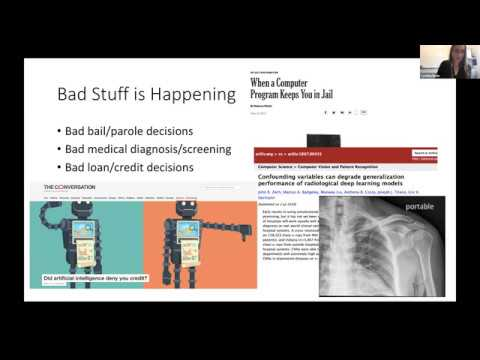

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('I0yrJz8uc5Q', width="800", height="550")

Jay Alammar has a nice repository of [Explainable AI tools](https://ex.pegg.io/) and a cheat-sheet (below) that nicely summarizes things.

![image](https://ex.pegg.io/Explainable-AI-cheat-sheet-v0.2.1080.png)

Note that we have basically 2 avenues if we want to have an explainable system.  For this we need to define some more precise vocabulary 🗣:

1. Interpretable models - here, the model is interpretable by design.  For example, a decision tree doesn't really need a separate explanation because you can just "look" 👀 at it and understand it pretty well.

2. Explainable models - these require post-hoc explanation tools, which will be discussed below.

Post-hoc explanation tools require that the model, or pipeline, has already been fitted.  This is convenient we can perform training 🚆 and comparison ⚖, then select the pipeline we like the best and perform inspection 🔍 on it.

Model specific explanations:

---

Recall PCA.  When using this model, people often look at the loadings (coefficients on eigenvectors, possibly scaled by the square root of the eigenvalues) to understand how each feature plays a role in describing the data's "spread". Similarly, LDA has "scalings".  In OLS, and other linear models like logistic regression, we can look at the coefficients that are built into the mathematics underlying the model itself.  

If you are committed to using a certain model, this is perfectly acceptable.  

❓ Q: But what if I need to choose between several different models?  How do we factor in, not only performance, but also how the models are "thinking" especially when different models might have different "explanation" methodologies.

🙋 A: Use a model-agnostic approach instead to compare 🍎 to 🍎.

Model agnostic approaches

---

This refers to a set of methods that essentially try to treat the entire pipeline 🔩 like a black box ⬛ that it cannot inspect directly, but instead try to infer properties based on the relationships between the input and output of the pipeline.

🗣 A "black box model" is a model that does not reveal its inner workings, i.e., it cannot be understood just by looking at its parameters (like a neural net). The opposite is sometimes called a white box ⬜ which is interpretable. Model agnostic explaination methods treat all models as black boxes so as to be indendent of their details, regardless of what color box they are in reality.

Model agnostic methods are particularly helpful when using multiple models to perform the same task and they need to be compared.

From ["Model-Agnostic Interpretability of Machine Learning" by Ribeiro et al. (2016)](https://arxiv.org/abs/1606.05386):
> "Desirable aspects of a model-agnostic explanation system are:
>
> * Model flexibility: The interpretation method can work with any machine learning model, such as random forests and deep neural networks.
> * Explanation flexibility: You are not limited to a certain form of explanation. In some cases it might be useful to have a linear formula, in other cases a graphic with feature importances.
> * Representation flexibility: The explanation system should be able to use a different feature representation as the model being explained. For a text classifier that uses abstract word embedding vectors, it might be preferable to use the presence of individual words for the explanation."


Model agnostic approaches can be divided into 2 categories:

1. 🌎 They explain global, overall behavior, or
2. 🚶 They explain individual predictions

🔬 Here we will focus on tools that are applicable to tabular data (vs. "raw data" like text or images) since this is more common in chemometric applications.  

👉 Implicit in the "world" to "data" ("capture") step from Molnar's book is the expectation that the output is "featurized" into a table.  This is not always true, but is commonly the case in scientific applications since the application of scientific principles leads to hypotheses about what exactly to collect.  This is not always correct and raw data can sometimes hide information which is one reason deep learning can sometimes be a powerful tool for science and engineering!

⭐ PyChemAuth has a complete [tutorial here](https://pychemauth.readthedocs.io/en/latest/jupyter/api/model_inspection.html), but it may be useful to read the basic overview of each technique below before working through this.

## Permutation Feature Importance (PFI)


PFI is a 🌎 global model inspection method.  sklearn has an [implementation](https://scikit-learn.org/stable/modules/permutation_importance.html) we will rely on, but the algorithm is very straightforward.

How does it work?

---

The idea is that if a feature is globally important to a model, then changing its value will strongly cause the model's prediction to change significantly, on average.

The algorithm proceeds as follows:

1. For a fitted model and tabular dataset, $X$, measure the performance (e.g., accuracy or TEFF), $s$.
2. For each feature (column in $X$), $j$, shuffle the values and recompute the performance, $s_{k,j}$.
3. Repeat this shuffling $K$ times and average the drop in performance.

The average difference defines the importance, $i_j$, of feature $j$.

$$
i_j = s - \frac{1}{k} \sum_{k=1}^K s_{k,j}
$$

👉 PFI can be computed on the training set or held-out test set; however using a held-out test set is important since you can explicitly test to compare which features are important during training vs. when applied to unseen data. Features that are important to predictions made about the training set but not the test set might indicate the model is overfit to the training set, or that the test/train split is poor.

Pros and Cons

---

* Simple and easy to understand.
* Works for any pre-trained model using tabular data which has a `score` method.  This works for regression ($R^2$ in OLS, PLS) or classification / authentication (accuracy, $TEFF$)!

However,

* It can be [highly misleading if you have multiple correlated features](https://scikit-learn.org/stable/modules/permutation_importance.html#misleading-values-on-strongly-correlated-features), so you should try to remove any multicollinear columns before training the model in question (an important preprocessing step!).  This is because when two features are correlated but only one of the features is shuffled, the model still has "access" to the latter through its correlated feature. This can make it seem like neither feature is important, when in fact they are both important!  sklearn has a nice [example](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py) of this.

---
> ❗ Read the documentation for sklearn's implementation of [PFI](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance).
---

In [2]:
from sklearn.inspection import permutation_importance
?permutation_importance

## SHapley Additive exPlanations (SHAP)

In [ ]:
# Let's install PyChemAuth which includes the SHAP package
%pip install git+https://github.com/mahynski/pychemauth@main

In [1]:
import shap

[SHAP](https://shap.readthedocs.io/en/latest/index.html) can provide both local 🚶 and global 🌎 explanations.  This is based on [Shapley values](https://en.wikipedia.org/wiki/Shapley_value), a term coined by [Lloyd Shapley](https://en.wikipedia.org/wiki/Lloyd_Shapley) in 1953 which is the [core solution to cooperative game theory](http://www.library.fa.ru/files/Roth2.pdf#page=39) - he received a Nobel Prize in Economics for this in 2012.

Basically, any model output (e.g., probability of being a class member) can be "explained" by pretending each features is a "player" in a game where the model itself is the game.  The model output, or "payout" from the game, can be broken down in a "fair" way using game theory!  This idea dates back to 2010 in [this paper](https://www.jmlr.org/papers/volume11/strumbelj10a/strumbelj10a.pdf?ref=https://githubhelp.com), but due to algorithmic improvements which make this more practical it has now become substantially more popular than when it was originally introduced.

> [What does "fair" mean?](https://christophm.github.io/interpretable-ml-book/shapley.html#the-shapley-value)  In game theory, there are 4 properties which, when simultaneously satisfied, can be considered a definition of a fair payout: Efficiency, Symmetry, Dummy and Additivity. You can [prove](https://en.wikipedia.org/wiki/Shapley_value#Properties) that the Shapley value is the only attribution method that satisfies these properties so it is a unique solution to fairness!

🤯 The Shapley values are the UNIQUE solution to this fair breakdown.  What is even more amazing about this approach is that we do not need any information about the game itself!  Thus we can treat the model, or the entire pipeline(!), as a black box and use the SAME explanation methodology.

![image](https://shap.readthedocs.io/en/latest/_images/shap_header.png)

The creators of SHAP have an excellent [introduction and tutorial](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html) on using this to understand and explain models which you should read.  As a simple illustration of what SHAP can do for you, consider the following example.

Imagine we have a dataset with 3 features, $X$, some target, $y$, and a model that is designed to predict this as follows:

```python
X = np.array(
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]
    ]
)

y = [0.5, 1.0, 0.25]

model = my_pipeline.fit(X, y)

y_pred = model.predict(X)
y_pred = [0.4, 1.5, 0.5]
```

SHAP computes the average prediction over the dataset it is given (`np.mean(y_pred) = 0.8`) then breaks down the difference between this "background" and each row's prediction in a way that adds up to the difference.  For example:

💡 Recall how we discussed different [metrics like $R^2$ reflect performance against a baseline](https://github.com/mahynski/chemometric-carpentry/blob/c894c992c2bd3a2a221b8cc11391cab068ca1330/notebooks/1.4_Statistics_Background.ipynb) which is the "simplest, reasonable but uninformed" approach (like predicting the average in regression, or the most common class in classification)?  SHAP is essentially breaking down the model's "intelligence" beyond this baseline in an ➕ additive way!

```python
shap_values = np.array(
    [
        [-0.1, -0.2, -0.1],
        [0.2, 1.0, -0.5],
        [1.0, -1.0, -0.3]
    ]
)
```

Observe, how for the first row in $X$ the sum of the `shap_values` = -0.1 + -0.2 + -0.1 = -0.4, is the difference between the background and the model's prediction (0.8 - 0.4 = y_pred[0] = 0.4).

---
> ❗ Verify this property for all rows.
---

The SHAP value reflects how significantly each feature contributes to the model's decision making process.  For the first row, the second feature is twice as significant as features 1 and 3.

👉 Any given row provides a local 🚶 explanation of the model's prediction for that sample.  If we average the absolute value of each column across the dataset we can get a ranking of which features are the most important.  This is a 🌎 global explanation.  SHAP can do both!

```python
global_expl = np.mean(np.abs(shap_values), axis=0)

global_expl = [0.43, 0.73, 0.3]
```
According to this contrived example, feature 2 is the most significant while feature 3 is the least.



### Shapley Values (Theory)

Motivation from Linear Models

---

Consider a linear model, $y(\vec{x}) = b_0 + \sum_{i=1}^p b_i x _i$.  The contribution (beyond the baseline) of the $j^{th}$ feature to the prediction for observation $\vec{x}$ in $X$ is easy to understand.  [It is just](https://christophm.github.io/interpretable-ml-book/shapley.html#the-shapley-value-in-detail):

$$
\phi_j(y) = b_j x_j - E(b_j X_j) = b_j x_j - b_j E(X_j) = b_j (x_j - \bar{X_j})
$$

If we know all of these contributions for all features, observe that:

$$
\begin{equation}
\begin{split}
\sum_{j=1}^p \phi_j(y) & = \sum_{j=1}^p \left( b_j x_j - b_j E(X_j) \right) \\
& = \left( b_0 + \sum_{j=1}^p b_j x_j \right) - \left( b_0 + \sum_{j=1}^p b_j E(X_j) \right) \\
& = y(\vec{x}) - E(y(X)) \\
& = y(\vec{x}) - \bar{y}
\end{split}
\end{equation}
$$

Thus, we arrive at a convenient expression:

$$
y(\vec{x}) = \sum \phi_j  + \bar{y}
$$

🤯 However, these simple derivations apply only for a linear model.  But what if we could get some value $\phi_j$ for any model that still had these properties?!  That is what a Shapley value is, and why SHAP let's us extend simple, intuitive explanations from linear models to ones which are arbitrarily complex (even things like ChatGPT!)

🔬 SHAP also has some incredible mathematical properties and is one of the most popular methods for interrogating models.  It can be fairly expensive and difficult to compute for large datasets, though.  But for the scale of data we typically encounter in chemometric applications we can use this just fine!

Definition of Shapley Value

---

🤔 To understand how SHAP uses Shapley values to break down "credit" across the features we need to dive a bit deeper.

> Here is an intuitive explanation of a Shapley value from [Molnar's book](https://christophm.github.io/interpretable-ml-book/shapley.html#intuition):
> "An intuitive way to understand the Shapley value is the following illustration: The feature values enter a room in random order. All feature values in the room participate in the game (= contribute to the prediction). The Shapley value of a feature value is the average change in the prediction that the coalition already in the room receives when the feature value joins them."

Formally, [the Shapley value](https://christophm.github.io/interpretable-ml-book/shapley.html#the-shapley-value), $\phi_j(f)$, for feature $j$ is defined for some output function, $f$, as a sum over all possible coalitions, $S$:

$$
\phi_j(f) = \sum_{S \subseteq \{1, \cdots, p\} \setminus \{j\}} \frac{|S|!(p - |S| - 1)!}{p!} \left[  f(S \cup \{j \} ) - f(S) \right] =  \sum_{S \subseteq \{1, \cdots, p\} \setminus \{j\}} \frac{|S|!(p - |S| - 1)!}{p!} \bar{\Delta}_{S,j}(f)
$$

where $S$ is the set of features in the coalition "playing" the game. Clearly, we need to tackle 2 practical challenges:

1. How do actually evaluate a model (which needs values for all inputs) when only a subset of features, $S$, are "playing the game", $f$?  In other words, how do we compute the term inside the summation, $\bar{\Delta}_{S,j}(f)$?

2. How can we practically compute this for all possible coalitions of features when there are more than a very small number of them ($p$ is large)?  Since a feature can either participate (1) or not (0), there are $2^p$ possible coalitions! In other words, the summation can have a lot of terms in it.

The first problem can be solved by "averaging" over feature values for those features not present in the game; that is, the marginal contribution of feature $j$ is estimated using Monte Carlo integration methods.  That is why we need a background (often the training set) to compute this over, as you will see below.  However, because features can be correlated there can be complications just like with PFI.






---
> ❗ Read the documentation for SHAP's ExactExplainer.
---

In [2]:
?shap.ExactExplainer

While the exact approach is feasible for a small number of features ($p \sim 10$) the second problem makes an exact calculation over all $2^p$ coalitions intractable in many cases.  Thus, some simplifying assumptions are required. There are several variations found in the [SHAP](https://shap.readthedocs.io/en/latest/index.html) python package we will discuss below.

In principle, you can [approximately calculate the Shapley value](https://christophm.github.io/interpretable-ml-book/shapley.html#estimating-the-shapley-value) for a feature, $j$ using Monte Carlo sampling.  This simple, but inexact and relatively inefficient method is nonetheless easy to express:

$$
\phi_j ≈ \frac{1}{M} \sum_{m=1}^M  \left( f(x_{+j}^m) - f(x_{-j}^m) \right)
$$

where $x^m_{+j}$ is based on $x$ but has had a random number of feature values replaced by feature values from a random data point $z$, except for feature $j$. $x^m_{-j}$ is similar, but the feature value for feature $j$ has also been replaced by the value in sample $z$.  An extension of the[ originally proposed algorithm](https://www.jmlr.org/papers/volume11/strumbelj10a/strumbelj10a.pdf?ref=https://githubhelp.com) is implemented in the [SHAP python package](https://shap.readthedocs.io/en/latest/generated/shap.SamplingExplainer.html#shap.SamplingExplainer) for reference.  

👆 Improvements over this baseline algorithm have been the subject of much research, and several are discussed below.


---
> ❗ Read the documentation for SHAP's SamplingExplainer.
---

In [3]:
?shap.SamplingExplainer

Kernel SHAP

---

Another alternative is [Kernel SHAP](https://christophm.github.io/interpretable-ml-book/shap.html#kernelshap).  The main innovation here is that [the authors showed how to estimate Shapley values using a linear regression approach](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf).  Assume we have an explanation model, $g(\vec{z})$, for a single observation, $\vec{x}$:

$$
g(\vec{z}) = \phi_0 + \sum_{j=1}^p \phi_j z_j
$$

where $\vec{z} \in \{0, 1\}^p$ is the coalition vector (which specifies if a feature is participating or not), and $\phi_j$ is feature attribution for feature $j$.  The authors showed that minimizing the weighted sum of squares given below allows you to solve for these $\phi_j$ values, which are indeed, Shapley values in this case:

$$
\mathcal{L}(f, g, \pi_x) = \sum_{ \vec{z} \in Z} \left[ f(h_x(\vec{z})) - g(\vec{z}) \right]^2 \pi_x(\vec{z})
$$

Here, $h_x(\vec{z})$ is a function which, given a coalition $\vec{z}$, takes an point $\vec{x}$ and keeps the features for which $z_j = 1$ but replaces those with $z_j = 0$ with values from a randomly sampled data instance.  $Z$ refers to the set of all coalitions in the training set - it is not the same as $X_{\rm train}$! Here is [graphic from Molnar's book](https://christophm.github.io/interpretable-ml-book/shap.html#kernelshap) illustrating how $h_x(\vec{z})$ works:

![image](https://christophm.github.io/interpretable-ml-book/images/shap-simplified-features.jpg)


The kernel defines the weight given to each squared error term which depends on the size of the coalition, $|z|$ (number of 1's present):

$$
\pi_x(\vec{z}) = \frac{p - 1}{ \binom{p}{|z|} |z| (p - |z|)}
$$

Because of this weighting function, we do not have a simple closed-form expression for the coefficients like we did in OLS.

❓ Q: So how exactly do we generate the training data that we should minimize this loss function over?  

🙋 A: For each point, $\vec{x}$, we wish to explain we randomly generate many $\vec{z}$ and use $h_x(\vec{z})$ to create a training dataset.

The procedure goes like this:

1. Randomly sample many coalitions to produce a matrix $Z$ whose rows are the generated $\vec{z}$ values (i.e., flip a coin $p$ times to create a sequence of 0s and 1s to make a row).  You can choose how many samples to make, but the more the better.

2. Use $h_x(\vec{z})$ to map each row in $Z$ from 0s and 1s back to "real" data values (e.g., "17" and "pink" above).  Many different rows can be created from the same sequence of 0s and 1s because the 0s are replaced values from randomly drawn background instances.  Again, more is better.

3. Plug each row into the function you are explaining, $f$, to get a prediction.

4. Fit the weighted differences by minimizing $\mathcal{L}$ to solve for $\phi$.

The SHAP authors provide an simple python implementation [here](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Simple%20Kernel%20SHAP.html) which makes things very clear and we recommend you check it out.

❌ Kernel SHAP is considered outdated and more optimized methods of estimating Shapley values now exist - still it is instructive to understand this method.





---
> ❗ Read the documentation for SHAP's KernelExplainer.
---

In [4]:
?shap.KernelExplainer

🤔 Kernel SHAP requires that we do a lot of sampling to generate $Z$, which is balanced against the computational effort.  If we look at the kernel we can gain insight into some computational improvements. 🏃

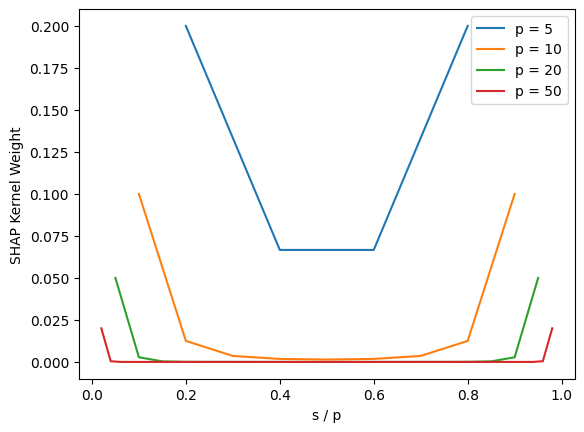

In [5]:
import scipy
import matplotlib.pyplot as plt

def shapley_kernel(p, s):
    if s == 0 or s == p:
        return 10000 # we would divide by 0 in the kernel below, so instead bound the value by a large number
    return (p - 1) / (scipy.special.binom(p, s) * s * (p - s))

def compute_importances(p):
    weights = []
    ratio = []
    for s in range(1, p): # Let's ignore the endpoints of s = 0, s = p
        weights.append(shapley_kernel(p, s))
        ratio.append(s / p)
    return ratio, weights

for p in [5, 10, 20, 50]:
    x, y = compute_importances(p)
    plt.plot(x, y, '-', label=f'p = {p}')
plt.legend(loc='best')
plt.xlabel('s / p')
_ = plt.ylabel('SHAP Kernel Weight')

It is clear that as $p$, the number of features (i.e., the width of the $X$ matrix) increases the coalitions with either only 1 feature or all the features except one matter to the linear regression used to estimate the Shapley values.  By [focusing on theses "endpoint" coalitions](https://christophm.github.io/interpretable-ml-book/shap.html#kernelshap) and working inward you can improve your estimates with reduced computational cost!  [Christoph Molnar offers some intuition about this](https://christophm.github.io/interpretable-ml-book/shap.html#kernelshap):

> "We learn most about individual features if we can study their effects in isolation. If a coalition consists of a single feature, we can learn about this feature's isolated main effect on the prediction. If a coalition consists of all but one feature, we can learn about this feature's total effect (main effect plus feature interactions). If a coalition consists of half the features, we learn little about an individual feature's contribution, as there are many possible coalitions with half of the features."




An Even Faster Approximation

---

Even with Kernel SHAP we still need to sample lots of coalitions (and "real" version of them) to get a good estimate of the Shapley values.  A [recent paper](https://www.jmlr.org/papers/v23/21-0439.html) illustrated an even faster way to get this estimate, which is implemented as the [permutation explainer](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/explainers/Permutation.html) in the SHAP package. Although still approximate (so is Kernel SHAP), it is very accurate and efficient - so much so it is the default in SHAP for "large" datasets.  Here is how it works:

1. For a point we want to explain, $\vec{x} = (x_1, x_2, x_3)$, create a permutation of these features (i.e., shuffle them up).  For example, we might now have $(x_2, x_3, x_1)$.

2. Moving from left to right we create coalitions incrementally, then evaluate using the method described for Kernel SHAP (Monte Carlo sampling); i.e., $f(h_x(\vec{z}))$.
    * First, add $x_2$ to $\varnothing$.  Compute $\bar{\Delta}_{+x_2}$.
    * Next, add $x_3$ to $\{x_2\}$. Compute $\bar{\Delta}_{+x_3}$.
    * Next, add $x_1$ to $\{x_2, x_3\}$. Compute $\bar{\Delta}_{+x_1}$.

3. Repeat this but in reverse order ("[antithetic sampling](https://en.wikipedia.org/wiki/Antithetic_variates)").
    * First, add $x_1$ to $\varnothing$. Compute $\bar{\Delta}_{-x_1}$.
    * Next, add $x_3$ to $\{x_1\}$. Compute $\bar{\Delta}_{-x_3}$.
    * Next, add $x_2$ to $\{x_1, x_3\}$. Compute $\bar{\Delta}_{-x_2}$.

The allows us to estimate the marginal contribution of each feature by looking at the differences between steps.  In fact, we get 2 estimates per feature between the forward and reverse sweeps (which we can simply average).  This can be repeated multiple times to get better estimates.

For each iteration, $k$, the first step in both the forward and reverse directions compute a single feature's main effect since it is added to "nothing"; the last step in the iteration computes what happens when those features are removed from a coalition of all others.  Intermediate steps focus on more complex coalitions, but by doing this in order we can compute all of these terms very efficiently by reusing coalitions.

If we have an ordering, $o(k)$, then we can estimate the Shapley value after $m$ sweeps (forward + backward) as:

$$
\phi_j = \frac{1}{2m} \sum_{k=1}^m \left( \bar{\Delta}_{o(k), +j} + \bar{\Delta}_{o(k), -j} \right)
$$


⚠ This "permutation" is NOT to be confused with PFI!

---
> ❗ Read the documentation for SHAP's PermutationExplainer.
---

In [6]:
?shap.PermutationExplainer

### Computing SHAP Values (Practice)



One way to interpret SHAP values is that they extend the idea of looking at coefficients in linear models (e.g., scalings in LDA or loadings in PCA) to non-linear cases.  Let's look at how SHAP values compare to some of the "explanation" methods we already encountered.



#### Linear Models

In [7]:
import sklearn
import numpy as np

# Create some fake data that has a multilinear correlation
np.random.seed(42)
X = np.random.random((50, 5))
y = -0.3*X[:,0] - 2.0*X[:,1] + 5.1*X[:,2] # The final 2 features we will assume do not contribute

# Build a model
model = sklearn.linear_model.LinearRegression().fit(X, y)

# Explain the model using an exact method
explainer = shap.ExactExplainer(
    model=model.predict,
    masker=X,
)
shap_values = explainer(X)

In [8]:
# Observe the mean prediction ...
np.mean(model.predict(X))

1.5124612164521287

In [9]:
# ... is the "base value" for each prediction
shap_values.base_values

array([1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122])

In [10]:
# The base_value + sum(shap_values) give the PREDICTED model output
print('Prediction\tShapley Sum')
print('---------------------------')
for ind in range(5):
    print("%.6f"%model.predict(X[ind:ind+1])[0], "\t", "%.6f"%(shap_values.base_values[ind] + np.sum(shap_values.values[ind])))

Prediction	Shapley Sum
---------------------------
1.719378 	 1.719378
4.254533 	 4.254533
2.299462 	 2.299462
2.012752 	 2.012752
1.027394 	 1.027394


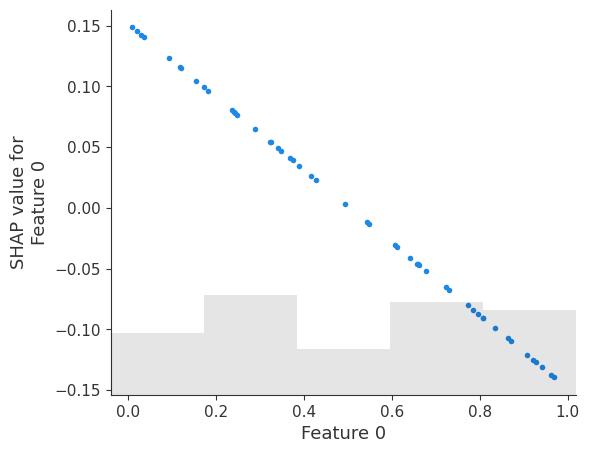

In [11]:
# Observe the slope of the line = 0.3 = feature 0 coefficient.
# In other words: shap_0 / x_0 = b_0
shap.plots.scatter(shap_values[:, 0])

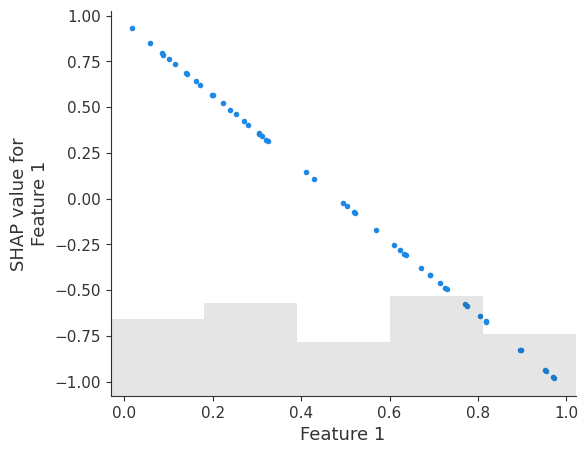

In [12]:
# Observe the slope of the line = -2.0 = feature 1 coefficient.
shap.plots.scatter(shap_values[:, 1])

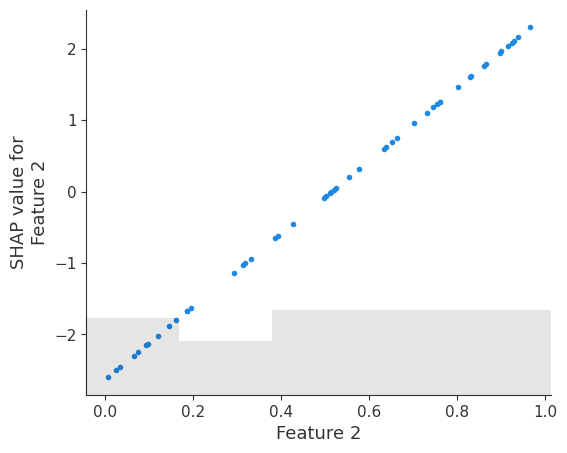

In [13]:
# Observe the slope of the line = 5.1 = feature 2 coefficient.
shap.plots.scatter(shap_values[:, 2])

Why is the slope equal to these coefficients?  For our linear model we have

$$
y_{\rm pred} = b_0 + \sum_{i=1}^p b_i x_i,
$$

and our Shap values are additive such that

$$
y_{\rm pred} = \phi_0 + \sum_{i=1}^p \phi_i.
$$

So each $\phi_i = b_i x_i$, thus $\phi_i / x_i = b_i$.  This is strictly true only for linear models with uncorrelated features like this example.



In [14]:
# You can rename the features manually if you like
shap_values.feature_names = ['F0', 'F1', 'F2', 'F3', 'F4']

[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]


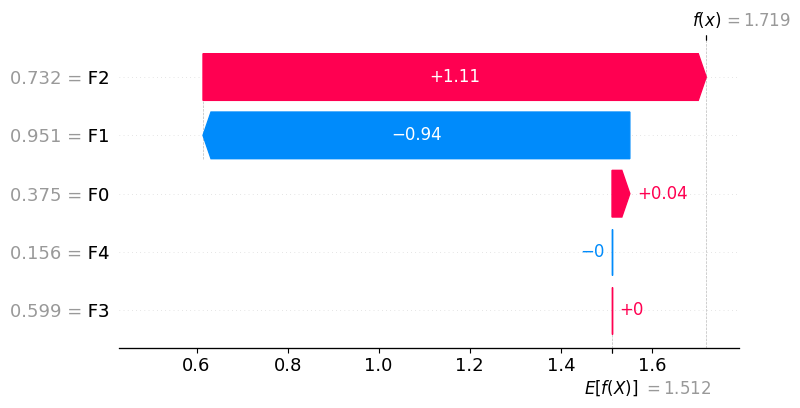

In [15]:
# Individual explanations vary because the VALUE of the features also vary
sample_ind = 0
print(X[sample_ind])
shap.plots.waterfall(shap_values[sample_ind])

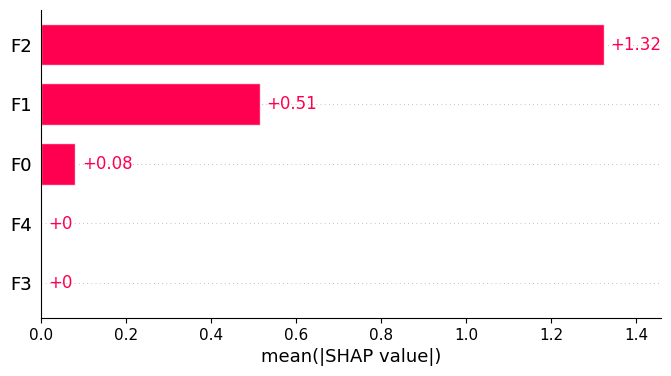

In [16]:
# You can see a global explanation by looking at the average absolute value of these Shapley values
shap.plots.bar(shap_values)

In [17]:
# The relative significance of features is given by the ratio of (absolute) SHAP values
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=0)
coefs = [-0.3, -2.0, +5.1, 0.0, 0.0]

print('i \t', 'SHAP Ratio', '\t', 'Coefficient Ratio')
print('---------------------------------------------')
for i, (ave_shap_, coef_) in enumerate(zip(mean_abs_shap, coefs)):
    print(i, '\t', "%.4f"%(ave_shap_ / mean_abs_shap[0]), '\t', "%.4f"%(np.abs(coef_ / coefs[0])))

i 	 SHAP Ratio 	 Coefficient Ratio
---------------------------------------------
0 	 1.0000 	 1.0000
1 	 6.4837 	 6.6667
2 	 16.6943 	 17.0000
3 	 0.0000 	 0.0000
4 	 0.0000 	 0.0000


Features contribute the same amount (relatively) in all cases - this is not always true since non-linear models or correlations can come into play.  This example has assumed completely decorrelated features!

❗ This also illustrates why standardizing (or not) your data will affect the Shapley values.  Generally, you should do this so that way these values reflect the importance of each feature and are not influenced by units or scale.

#### PCA

SHAP can explain the output of any model - this includes transformers!  A transformation based on PCA involves taking the matrix product of the $X$ matrix with its principal eigenvectors, $P$ (loadings matrix), to obtain the "scores", $T$.

$$
T = XP
$$

 The coefficients on the eigenvector(s) used are linear coefficients on the inputs so we can use SHAP to recover these as well!

In [19]:
import pychemauth
from pychemauth.classifier.pca import PCA

In [20]:
# Let's use the diabetes dataset
from sklearn.datasets import load_diabetes as load_data
from sklearn.model_selection import train_test_split

In [21]:
# But note that one of the features here is actually categorical ("sex")
# but has been encoded as a floating point.  We are going to get rid of that
# feature for this analysis.
print(load_data(return_X_y=False, as_frame=True)["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [22]:
X, y = load_data(return_X_y=True, as_frame=True)
X.drop("sex", axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
feature_names = list(X.columns)

In [23]:
from pychemauth.preprocessing.scaling import CorrectedScaler

scaler = CorrectedScaler(with_mean=True, with_std=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
pca_model = PCA(
    n_components=2,
    robust=False,
).fit(X_train)

In [25]:
# Since SHAP expects a simple function to call with a query, X, we need to write
# a little wrapper to select the dimension we are going to explain.
class ScoreWrapper:
    def __init__(self, model, k=0):
        self.model = model
        self.k = k

    def __call__(self, X):
        # Return the kth column (score)
        return self.model.transform(X)[:, self.k]

In [26]:
pc1 = ScoreWrapper(pca_model, k=0)
pc2 = ScoreWrapper(pca_model, k=1)

explainer_1 = shap.ExactExplainer(
    model=pc1,
    masker=X_train,
)

explainer_2 = shap.ExactExplainer(
    model=pc2,
    masker=X_train,
)

shap_values_1 = explainer_1(X_train)
shap_values_2 = explainer_2(X_train)

ExactExplainer explainer: 354it [00:14,  5.99it/s]                         
ExactExplainer explainer: 354it [00:13,  4.96it/s]                         


In [27]:
# Observe that baseline + Shapley values add up to the score location correctly
import numpy as np
sample_idx = 10

print(
    np.sum(shap_values_1.values[sample_idx]) + shap_values_1.base_values[sample_idx],
    np.sum(shap_values_2.values[sample_idx]) + shap_values_2.base_values[sample_idx]
)

-1.6242049745116471 1.4965212498786702


In [28]:
pca_model.transform(X_train)[sample_idx]

array([-1.62420497,  1.49652125])

In [29]:
# Note that the base_values are not 0 even though X was centered.  This is
# because the base_value averages over the scores not X; just because X is
# centered does not mean that the scores are!
shap_values_1.base_values[0], shap_values_2.base_values[0]

(-0.04436185067157659, -0.004443058766511283)

In [30]:
shap_values_1.feature_names = feature_names

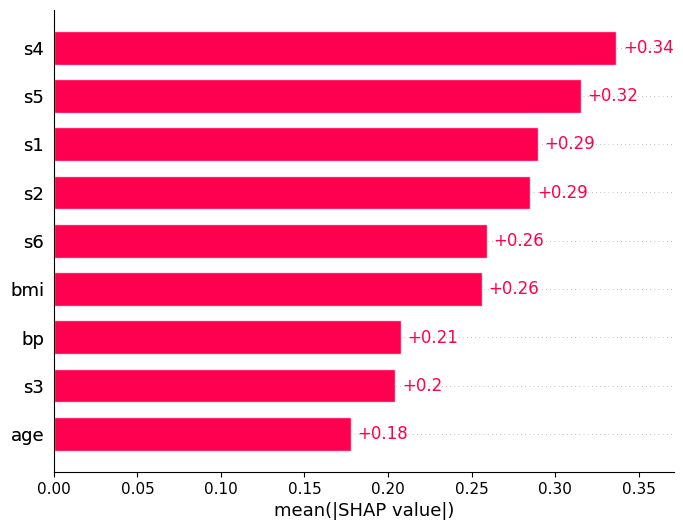

In [31]:
# Let's look at the Shapley values for the PC1
shap.plots.bar(shap_values_1, max_display=X_train.shape[1])

In [32]:
# We can compare this to coefficients on each feature in the first eigenvector.
# Observe the ordering is very similar same, but not magnitudes are not the same.

import numpy as np
sorted(zip(feature_names, np.abs(pca_model._PCA__pca_.components_.T[:,0])), key=lambda x:x[1], reverse=True)

[('s4', 0.4316242218583288),
 ('s5', 0.3912922724559383),
 ('s1', 0.36869191178675315),
 ('s2', 0.3632568002721173),
 ('s6', 0.33297029008991086),
 ('bmi', 0.3216415910930064),
 ('s3', 0.26399661716954664),
 ('bp', 0.2542851909202704),
 ('age', 0.20981887536356011)]

Text(0, 0.5, 'PC 2')

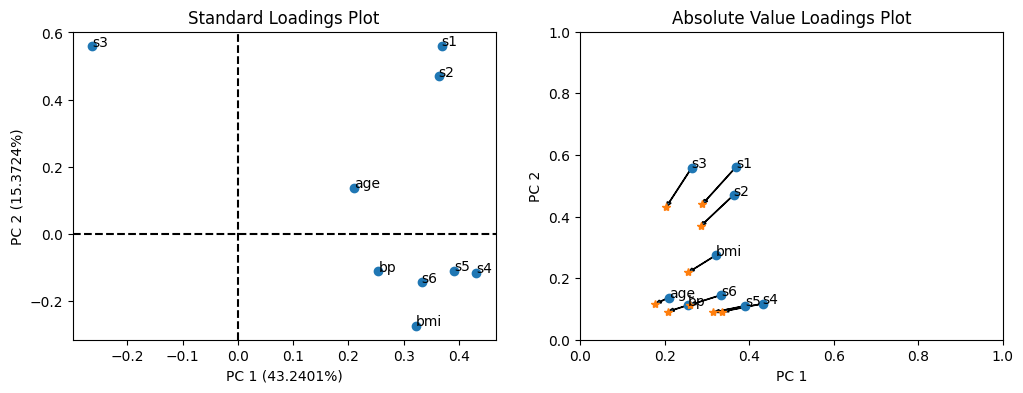

In [33]:
# To gain a little more insight, let's plot the loadings plot.  We will also
# move all the values into the first quadrant to compare the Shapley values.
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

axes[0].set_title('Standard Loadings Plot')
res = pca_model.plot_loadings(ax=axes[0], feature_names=feature_names)

scale_ = 1.00

axes[1].set_title('Absolute Value Loadings Plot')
for i, (x_, y_, shap_x_, shap_y_) in enumerate(
    zip(
        np.abs(res.lines[0].get_xdata()),
        np.abs(res.lines[0].get_ydata()),
        np.mean(np.abs(shap_values_1.values), axis=0),
        np.mean(np.abs(shap_values_2.values), axis=0)
    )
):
    axes[1].plot([x_], [y_], 'o', color='C0')
    axes[1].text(x_, y_, X.columns[i])

    axes[1].plot([shap_x_*scale_], [shap_y_*scale_], marker='*', color='C1')
    plt.arrow(x_, y_, shap_x_*scale_-x_, shap_y_*scale_-y_, head_width=0.01, length_includes_head=True)

axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')

---
> ❗ Play the with the `scale_` variable above to see how multiplying the SHAP values by a constant gets you approximately the same results as the loadings. HINT: try scale_ = 1.28.
---

What's perhaps most important about this is that we can create "loadings" plots for ANY dimensionality reduction model, not just PCA!  For example, let's consider a popular, but highly non-linear approach called [isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html).

In [34]:
import sklearn

iso_model = sklearn.manifold.Isomap(
    n_components=2,
    n_neighbors=5,
).fit(X_train, y_train)

iso1 = ScoreWrapper(iso_model, k=0)
iso2 = ScoreWrapper(iso_model, k=1)

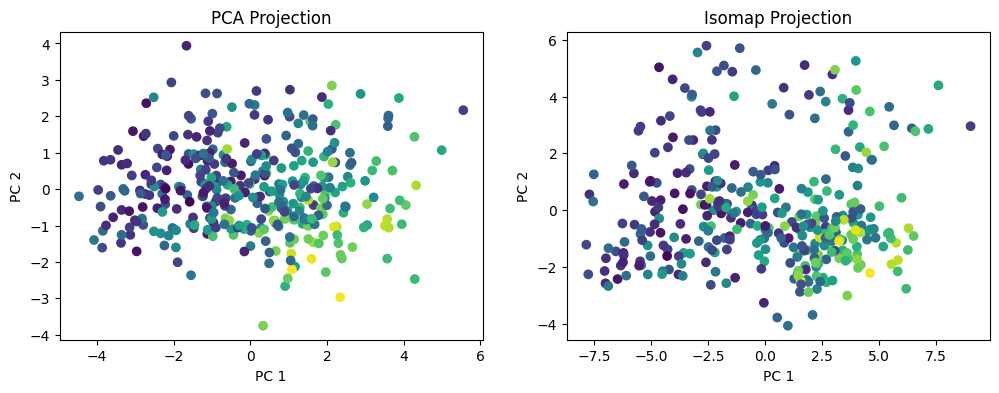

In [35]:
# For comparison, let's plot the scores
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

axes[0].scatter(pc1(X_train), pc2(X_train), c=y_train, cmap='viridis')
axes[0].set_title('PCA Projection')

axes[1].scatter(iso1(X_train), iso2(X_train), c=y_train, cmap='viridis')
axes[1].set_title('Isomap Projection')

for ax in axes:
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')

In [36]:
explainer_1 = shap.PermutationExplainer(
    model=iso1,
    masker=X_train[:50], # This is just to speed up the calculation for demonstration - if you can wait, use the entire dataset
    seed=42
)

explainer_2 = shap.PermutationExplainer(
    model=iso2,
    masker=X_train[:50], # This is just to speed up the calculation for demonstration - if you can wait, use the entire dataset
    seed=42
)

shap_values_1 = explainer_1(X_train[:50])
shap_values_2 = explainer_2(X_train[:50])

PermutationExplainer explainer: 51it [01:00,  1.34s/it]
PermutationExplainer explainer: 51it [01:01,  1.46s/it]


Text(0.5, 1.0, 'Isomap "Loadings" Plot')

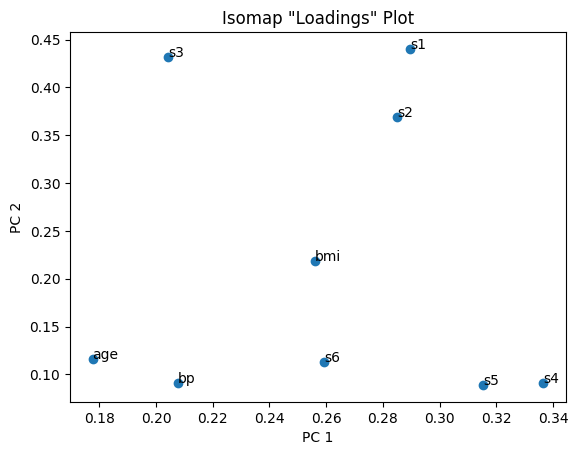

In [113]:
for i, (shap_x_, shap_y_) in enumerate(
    zip(
        np.mean(np.abs(shap_values_1.values), axis=0),
        np.mean(np.abs(shap_values_2.values), axis=0)
    )
):
    plt.plot([shap_x_], [shap_y_], 'o', color='C0')
    plt.text(shap_x_, shap_y_, X.columns[i])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Isomap "Loadings" Plot')

#### Correlated Features and Owen Values

One way to handle highly correlated features in your dataset is simply to try to remove the correlated features.  For example, we have already gone over hierarchical clustering during EDA (or part of a [pipeline](https://pychemauth.readthedocs.io/en/latest/pychemauth.preprocessing.html#pychemauth.preprocessing.feature_selection.CollinearFeatureSelector)) to downselect from group of known features.  Another way is to use a [Partition masker](https://shap.readthedocs.io/en/latest/generated/shap.maskers.Partition.html#shap.maskers.Partition) with a model agnostic explainer to do the Shapley value calculations.  This creates a "structured" game (i.e. a game with rules about valid input feature coalitions) where the structure is defined by a hierarchy of features - the resulting feature credit / attributions are called Owen values or hierarchical Shapley values.

This hierarchy needs to be defined, and is typically done by looking for correlations between features.  While there are many ways to do this, here we can rely on the same [collinear clustering (Ward-based)](https://pychemauth.readthedocs.io/en/latest/pychemauth.eda.html#pychemauth.eda.explore.InspectData.cluster_collinear) we have used so far.

---
> ❗ Read the documention for shap.masker.Partition.
---

In [37]:
?shap.maskers.Partition

This clustering defines groups of features which are masked/unmasked together. This leads to potentially more realistic manipulations of the model inputs since groups of clustered features are masked/unmasked simultaneously.

The partition approach in SHAP takes the structure to the limit of a binary tree.  Starting from the top of the tree, the features are split into 2 groups.  They compete to earn their net credit and each gets their fair share.  This credit is subdivided on each side of the tree by recursively repeating this procedure.  That way we end up with [2 nice features](https://shap.readthedocs.io/en/latest/generated/shap.PartitionExplainer.html#shap.PartitionExplainer):

1. A "balanced" hierarchy only has quadratic runtime (in term of the number of input features). This is in contrast to the exponential exact runtime of KernelExplainer or SamplingExplainer. In other words it scales as $\mathcal{O}(p^2)$ instead of $\mathcal{O}(2^p)$.

2. Feature correlations are "accounted for" in the sense that the total credit assigned to a group of tightly correlated features does not depend on how they behave if their correlation structure gets broken during the explanation's perturbation process.

Note, this doesn't fully eliminate problems with correlations, since you will have to break up tightly correlated features as you move down the clutering tree. However, it is reduced since this permutes fewer features; plus, we can simply focus on interpreting the group's SHAP value rather than placing to much faith on aspects of how it breaks down internally.

As in the examples provided in the SHAP [documentation](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/explainers/Exact.html), the example below shows that results do not often differ significantly from the default (Independent masker); the main advantage of using the the Partition masker is that it allows for much faster runtime.  This is especially important when analyzing things like spectra⚡ which may have 100s-1000s of features compared to other chemometric datasets 🔬 including things like stable isotopes and trace elements.


Text(0, 0.5, 'Complexity')

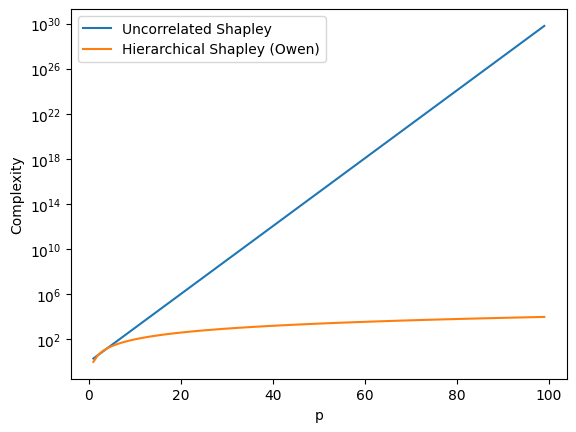

In [38]:
p = np.arange(1, 100)
plt.plot(p, 2.0**p, label='Uncorrelated Shapley')
plt.plot(p, p**2, label='Hierarchical Shapley (Owen)')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('p')
plt.ylabel('Complexity')

The Diabetes Dataset

---

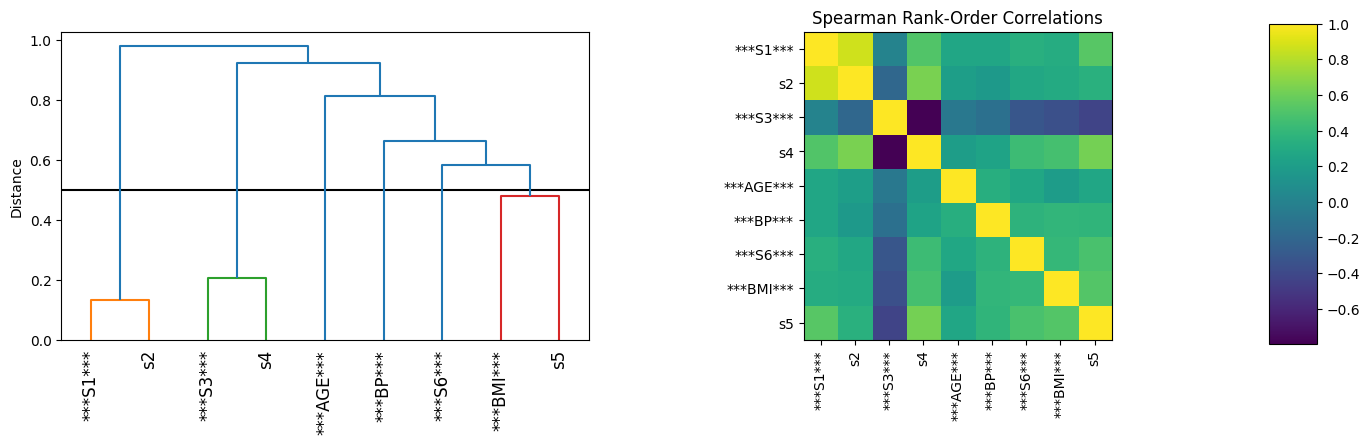

In [39]:
# This clustering reflects how tightly the features are correlated (via Spearman R)
# with each other, but does not necessarily tell us anything about how they are
# correlated with the output / prediction.
from pychemauth.eda.explore import InspectData
selected_features, cluster_id_to_feature_ids, _, linkage = InspectData.cluster_collinear(
    X=X_train,
    feature_names=feature_names,
    t=0.5,
    figsize=(16,4),
    return_linkage=True
)

In [40]:
# Use the linkage from Ward clustering above to create a structured game.
# This will tell us about how well these features explain the output.

explainer_partition = shap.ExactExplainer(
    model=pc1,
    masker=shap.maskers.Partition(X_train, max_samples=100, clustering=linkage)
)

shap_values_part = explainer_partition(X_train)
shap_values_part.feature_names = feature_names

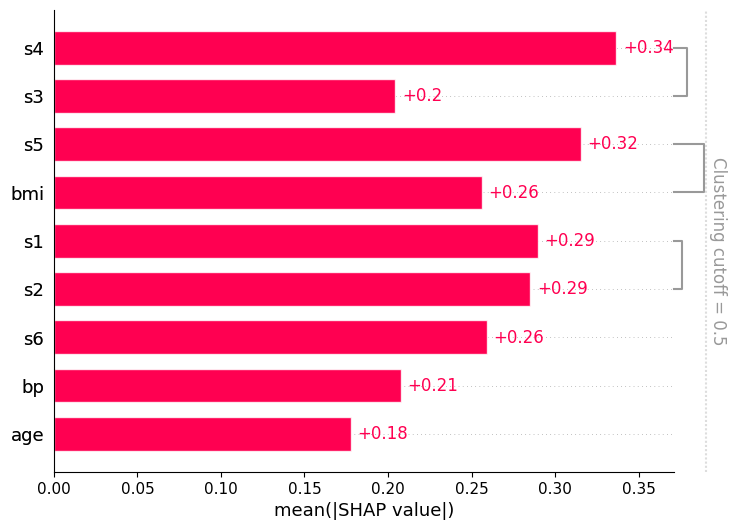

In [41]:
shap.plots.bar(shap_values_part, clustering_cutoff=0.5)

PGAA Spectra

---


Let's consider some spectral data from [this](https://doi.org/10.1007/s10967-023-09024-x) paper.  These were acquired using prompt gamma activation analysis (PGAA) and represent a "nuclear" / isotopic fingerprint of the material being analyzed.  These spectra can have 16k or more bins, but have been downsampled to ~4k already.  For the sake of demonstration, we will further downselect a portion of these spectra to make calculations fast and simple.

In [42]:
from pychemauth.datasets import load_pgaa
data_bunch = load_pgaa()

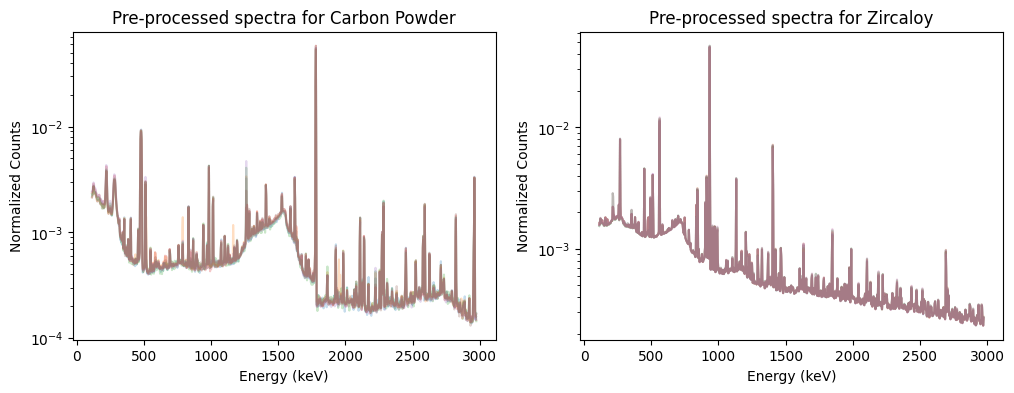

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

clip = 1000 # For demonstration purposes, let's just focus on a subset of the spectra

def plot(ax, name):
    mask = data_bunch['target'] == name
    for spectra in data_bunch['data'][mask]:
        ax.plot(data_bunch['feature_names'][:clip], spectra[:clip], alpha=0.25)
    ax.set_yscale('log')
    ax.set_xlabel('Energy (keV)')
    ax.set_ylabel('Normalized Counts')
    ax.set_title(f'Pre-processed spectra for {name}')

plot(axes[0], 'Carbon Powder')
plot(axes[1], 'Zircaloy')

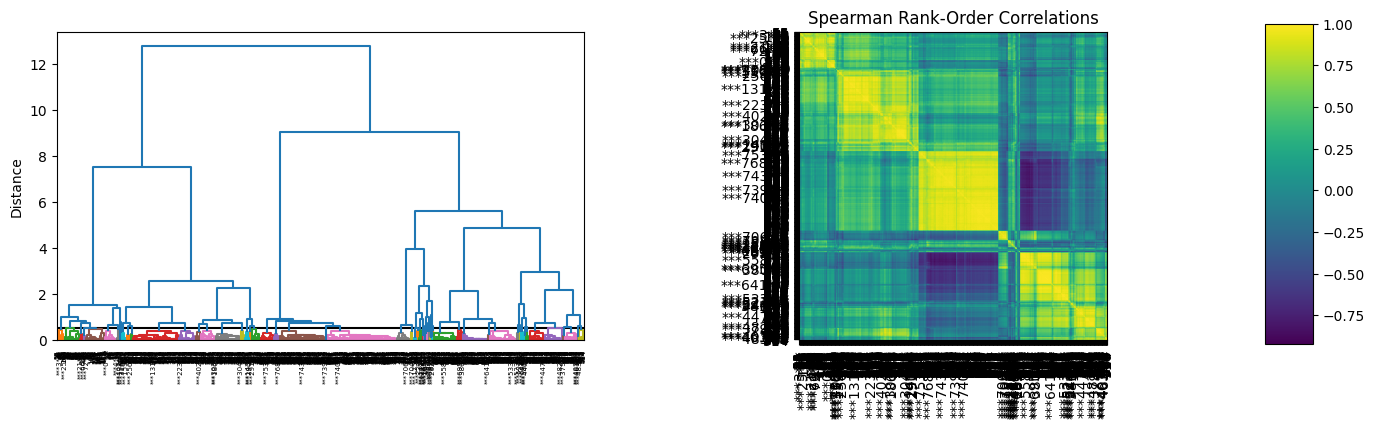

In [44]:
# Of course, spectra are very correlated over their energy range.

X = data_bunch['data'][:,:clip]
feature_names = data_bunch['feature_names'][:clip]

from pychemauth.eda.explore import InspectData
selected_features, cluster_id_to_feature_ids, _, linkage = InspectData.cluster_collinear(
    X=X,
    t=0.5,
    figsize=(16,4),
    return_linkage=True
)

One approach would be to reduce the features being used, then proceed to train the model based on the bins only.

```python
X_downsample = X[:, selected_features]

```

Instead, for demonstration purposes, let's not downsample and proceed with all the spectral bins we have clipped X to.

In [46]:
pca_model = PCA(
    n_components=2,
    robust=False,
).fit(X)

pc1 = ScoreWrapper(pca_model, k=0)
pc2 = ScoreWrapper(pca_model, k=1)

explainer_1 = shap.PermutationExplainer(
    model=pc1,
    masker=shap.maskers.Partition(
        X,
        max_samples=1, # Set this value low so the calculation runs quickly for demonstration purposes
        clustering=linkage
    ),
    seed=42,
)

explainer_2 = shap.PermutationExplainer(
    model=pc2,
    masker=shap.maskers.Partition(
        X,
        max_samples=1, # Set this value low so the calculation runs quickly for demonstration purposes
        clustering=linkage
    ),
    seed=42
)

shap_values_1 = explainer_1(
    X,
    max_evals=2001 # Set this value low so the calculation runs quickly for demonstration purposes
)
shap_values_2 = explainer_2(
    X,
    max_evals=2001 # Set this value low so the calculation runs quickly for demonstration purposes
)

PermutationExplainer explainer: 326it [00:35,  7.57it/s]                         
PermutationExplainer explainer: 326it [00:26,  8.18it/s]


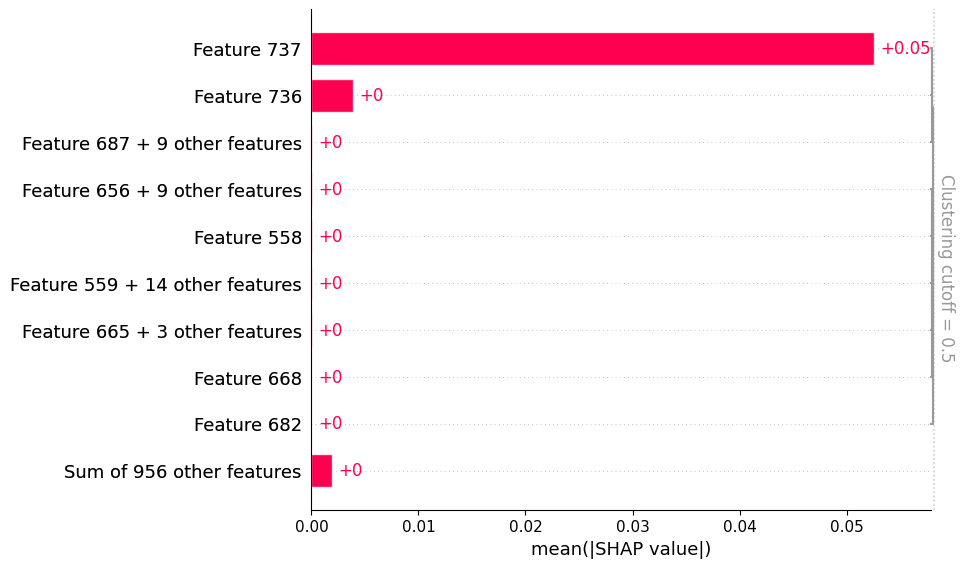

In [47]:
shap.plots.bar(shap_values_1, clustering_cutoff=0.5)

In [48]:
# This is the main peak associated with H that defines PC 1 in the original paper.
feature_names[737]

2223.7988

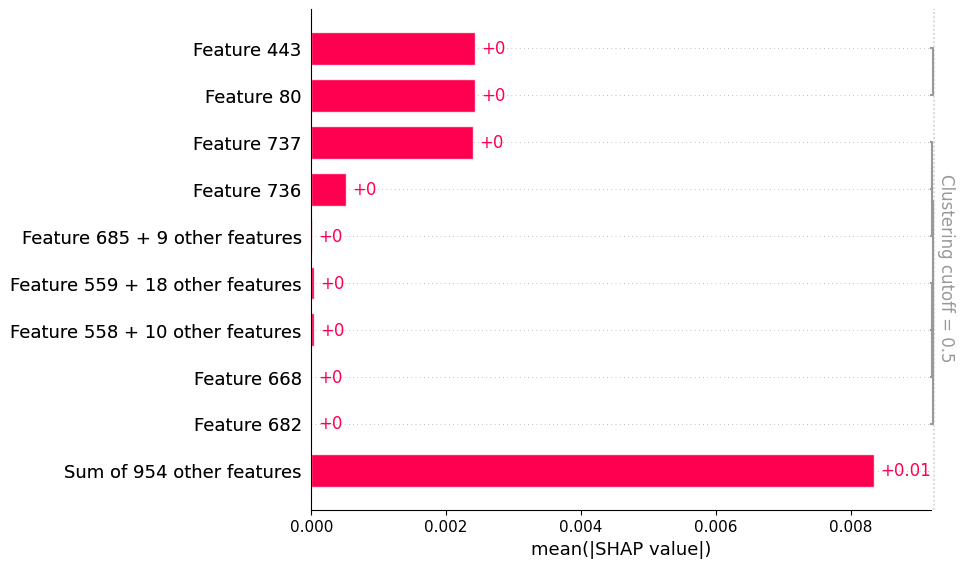

In [49]:
shap.plots.bar(shap_values_2, clustering_cutoff=0.5)

In [163]:
# These are the main peaks associated with Ti alloy which, in addition to the H peak,
# define PC 2 in the original paper.
feature_names[443], feature_names[80]

(1381.5333, 341.59326)

Text(0, 0.5, 'PC 2')

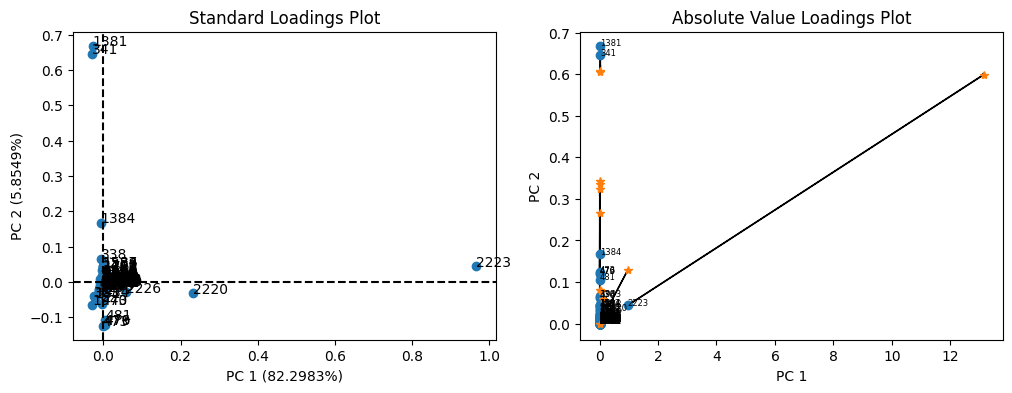

In [50]:
# To gain a little more insight, let's plot the loadings plot.  We will also
# move all the values into the first quadrant to compare the Shapley values.
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

axes[0].set_title('Standard Loadings Plot')
res = pca_model.plot_loadings(ax=axes[0], feature_names=['%d'%n_ for n_ in feature_names])

scale_ = 250.00 # With more background sampling (max_samples=1) a single scale brings the PCA and SHAP into better alignment

axes[1].set_title('Absolute Value Loadings Plot')
for i, (x_, y_, shap_x_, shap_y_) in enumerate(
    zip(
        np.abs(res.lines[0].get_xdata()),
        np.abs(res.lines[0].get_ydata()),
        np.mean(np.abs(shap_values_1.values), axis=0),
        np.mean(np.abs(shap_values_2.values), axis=0)
    )
):
    axes[1].plot([x_], [y_], 'o', color='C0')
    axes[1].text(x_, y_, '%d'%feature_names[i], fontsize=6)

    axes[1].plot([shap_x_*scale_], [shap_y_*scale_], marker='*', color='C1')
    plt.arrow(x_, y_, shap_x_*scale_-x_, shap_y_*scale_-y_, head_width=0.01, length_includes_head=True)

axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')

#### Logistic Regression

Now let's look at a logistic regression model.  So far we have examined / explained the output of (linear) regression models and some transformers (dimensionality reduction models).  Now let's look at a classification model to see an important caveat about WHAT (❓) we should be explaining.

Recall that logistic regression is a generalized linear model so it has the form

$$
g(p) = y = b_0 + \sum b_i x_i
$$

where $p$ is the probability we are modeling (in a binary case), and the link function, $g$, is the logit function (whose inverse is the logistic function):

$$
g(p) = {\rm ln} \left( \frac{p}{1-p} \right)
$$

$$
p = g^{-1}(y) = \frac{1}{1 + {\rm exp}(-y)}
$$

In this case, we could seek to explain 2 ✌ different things.

1. The argument of the link function ($y$), which is just a linear expression so we can interpret the coefficients directly.

2. The probability itself, $p$.

Recall that when $y$ is positive, $p > 0.5$, and when $y$ is negative, $p < 0.5$, so the origin ($y = 0$) is called a "decision boundary".

Let's define some vocabulary 🗣:
* A [decision boundary](https://en.wikipedia.org/wiki/Decision_boundary) is the boundary (often line or hyperplane) that divides the underlying space into sets, one for each class. In this case, it is $p = 0.5$ or $y = 0$.
* The [margin](https://en.wikipedia.org/wiki/Margin_(machine_learning) is the distance from a point to the decision boundary.  This is generally unbounded (i.e., can range from $-\infty < y < +\infty$).  In this case, the margin is just the value of $y$ since the boundary is at $y = 0$.
* A ["squashing function"](https://en.wikipedia.org/w/index.php?title=Squashing_function) is a function that is used to transform this unbounded margin to a bounded probability (i.e., $0 \le p \le 1$).  The most common example is the logistic function, which is used here.



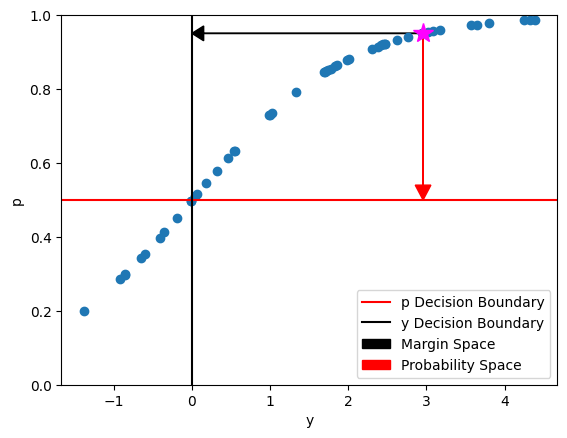

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Let's create a dummy model.  We can imagine that this model was learned from
# some data.  Here, we will just create one for simplicity.  Classifiers in
# sklearn and PyChemAuth have these functions (decision_function and
# predict_proba) implemented as illustrated below.
class DummyModel:
    def decision_function(self, X):
        return -0.3*X[:,0] - 2.0*X[:,1] + 5.1*X[:,2] # The final 2 features we will assume do not contribute

    def predict_proba(self, X):
        return 1.0 / (1.0 + np.exp(-self.decision_function(X)))

dummy = DummyModel()
np.random.seed(42)
X = np.random.random((50, 5))
y = dummy.decision_function(X)
p = dummy.predict_proba(X)

plt.plot(y, p, 'o')
plt.axhline(0.5, color='red', label='p Decision Boundary')
plt.axvline(0, color='k', label='y Decision Boundary')
plt.xlabel('y')
plt.ylabel('p')
plt.ylim(0, 1)

# Select a point and draw its margin and probability spaces
idx = 21
plt.plot([y[idx]], [p[idx]], marker='*', ms=15, color='magenta')
plt.arrow(y[idx], p[idx], -y[idx], 0, head_width=0.04, head_length=0.15, length_includes_head=True, color='k', label='Margin Space')
plt.arrow(y[idx], p[idx], 0, 0.5-p[idx], head_width=0.20, head_length=0.04, length_includes_head=True, color='red', label='Probability Space')

_ = plt.legend(loc='best')

In [52]:
# Let's explain the margin space first
explainer = shap.ExactExplainer(
    model=dummy.decision_function,
    masker=X,
)
shap_values = explainer(X)

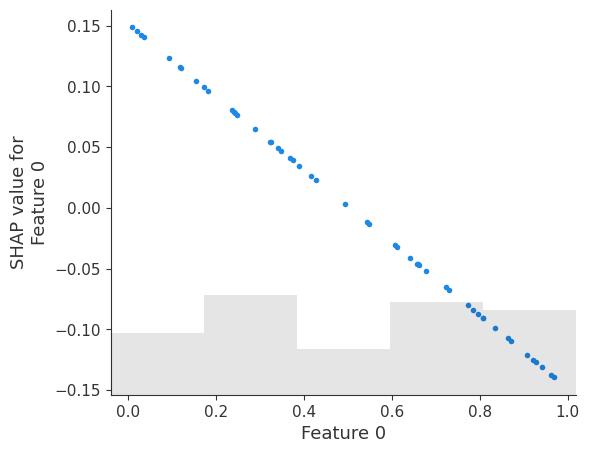

In [53]:
# We obtain the same results (as expected) as from our linear model example
shap.plots.scatter(shap_values[:, 0])

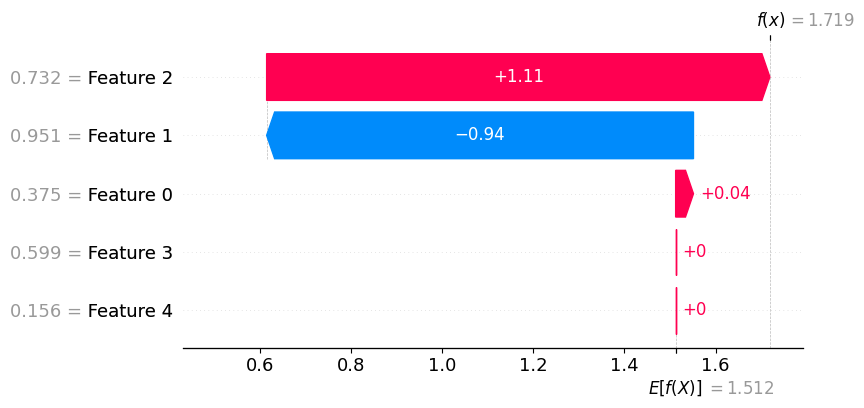

In [54]:
sample_ind = 0
shap.plots.waterfall(shap_values[sample_ind])

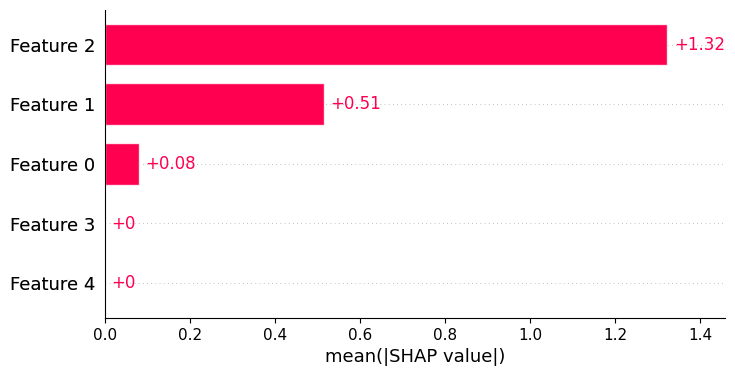

In [55]:
shap.plots.bar(shap_values)

In [56]:
# Let's explain the margin space first
explainer = shap.ExactExplainer(
    model=dummy.predict_proba,
    masker=X,
)
shap_values_prob = explainer(X)

In [57]:
# The base_value + sum(shap_values) give the PREDICTED model output
print('Prediction\tShapley Sum')
print('---------------------------')
for ind in range(5):
    print("%.6f"%dummy.predict_proba(X[ind:ind+1])[0], "\t", "%.6f"%(shap_values_prob.base_values[ind] + np.sum(shap_values_prob.values[ind])))

Prediction	Shapley Sum
---------------------------
0.848049 	 0.848049
0.985999 	 0.985999
0.908833 	 0.908833
0.882129 	 0.882129
0.736410 	 0.736410


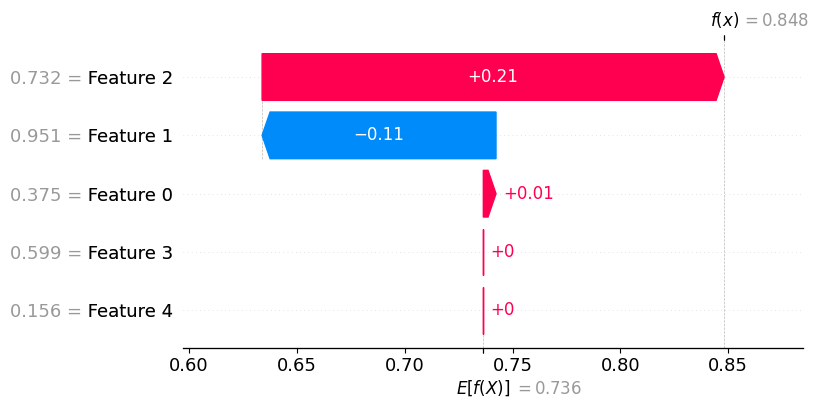

In [58]:
# Now we are explaining the probability!  Note that, as expected, we do not start from
# p = 0.5, but rather the background average over the dataset provided.
sample_ind = 0
shap.plots.waterfall(shap_values_prob[sample_ind])

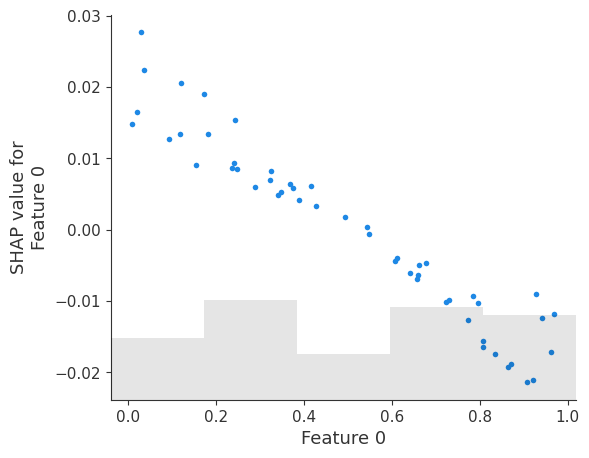

In [59]:
# The effects of features are NOT ADDITIVE in probability space.
shap.plots.scatter(shap_values_prob[:, 0])

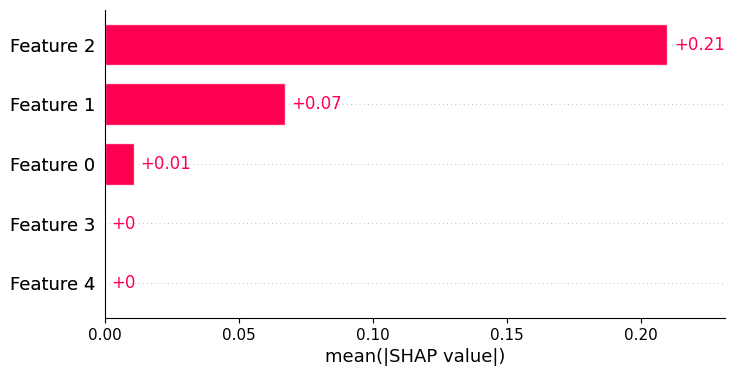

In [60]:
shap.plots.bar(shap_values_prob)

### Margin Space Explanations

⚠ For the logistic regression example above, the relative importance of features was the same regardless of whether we explained the model's margin space or its predicted probabilities. Even the ratios between the importances is not too different (verify this for yourself).   You might be inclined to believe that this would hold in general when using a [monotonic function](https://en.wikipedia.org/wiki/Monotonic_function) like the logistic function, to map the margin to a probability, but you would be incorrect!

❗ The importance of a feature when computed in margin space vs. probability space can change significantly.  Even the relative ordering can change!

It is not obvious which space (margin vs. probability) you should choose 🤷, and there is no consensus.  The recommendation is to explain "what you care about" which depends on the situation.  From the SHAP [documentation](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Squashing%20Effect.html):

> "The value of the margin space is then in the units of information, while the values in the probability space is in the units of probability. Which space you care about can be different in different situations. The margin space is better for adding and subtracting, and directly corresponds to “evidence” in an information-theoretic sense. However, if you only care about changes in % probability, not evidence, then you would be better off using the probability space."

👉 I recommend using the margin space for chemometric 🔬applications.  To see why, let's look at an example inspired by the SHAP [documentation](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Squashing%20Effect.html).



In [68]:
# Build a simple dataset where X is 500 x 2
N, p = 500, 2
np.random.seed(42)
X = np.random.randn(N, p)

class DummyModel:
    def decision_function(self, X):
        return (X[:, 0] > 0) * 2 + (X[:, 1] > 1.5) * 100 - 1

    def predict_proba(self, X):
        return 1.0 / (1.0 + np.exp(-self.decision_function(X)))

Let's take a look at this decision function a bit.  It resembles a regression tree.

* When $x_1 \le 0$ and $x_2 \le 1.5$ it returns -1 ($p < 0.5$),
* When $x_1 > 0$ and $x_2 \le 1.5$ it returns +3 ($p > 0.5$),
* When $x_1 \le 0$ and $x_2 > 1.5$ it returns 99 ($p >> 0.5$),
* When $x_1 > 0$ and $x_2 > 1.5$ it returns 101 ($p >> 0.5$),

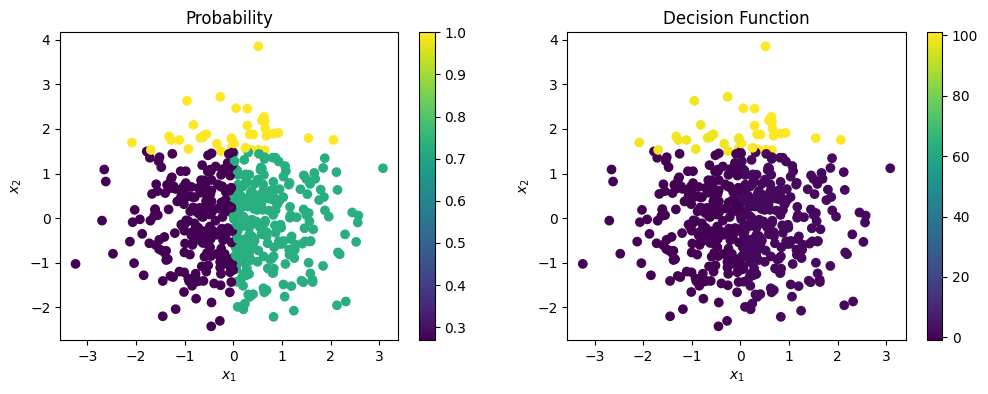

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

dummy = DummyModel()

sc = axes[0].scatter(X[:,0], X[:,1], c=dummy.predict_proba(X))
axes[0].set_title('Probability')
plt.colorbar(sc)

sc = axes[1].scatter(X[:,0], X[:,1], c=dummy.decision_function(X))
axes[1].set_title('Decision Function')
plt.colorbar(sc)

for ax in axes:
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')

In [70]:
# Let's look at some points near boundaries

X_test = np.array(
    [
        [-0.01, 0],
        [0.01, 0],
        [0, 2]
    ]
)

explainer_margin = shap.ExactExplainer(
    dummy.decision_function,
    X
)
shap_values_margin = explainer_margin(X_test)

explainer_proba= shap.ExactExplainer(
    dummy.predict_proba,
    X
)
shap_values_proba = explainer_proba(X_test)

shap_values_proba.feature_names = ['x_1', 'x_2']
shap_values_margin.feature_names = ['x_1', 'x_2']

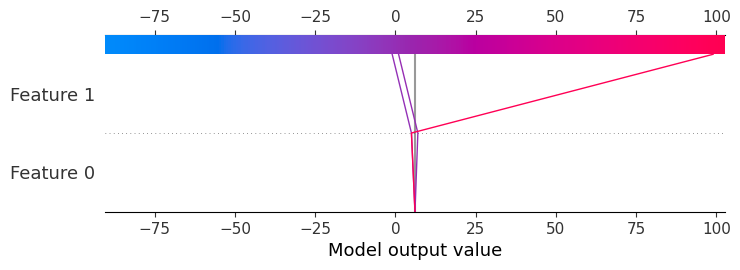

In [71]:
# Let's look at a breakdown of the margin space output
shap.plots.decision(shap_values_margin.base_values[0], shap_values_margin.values)

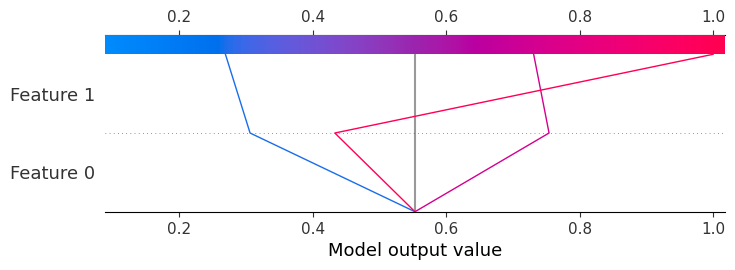

In [72]:
# Compared to the probability ...
shap.plots.decision(shap_values_proba.base_values[0], shap_values_proba.values)

Compare the Shapley values for each of these 3 data points.  The second feature, $x_2$, plays an important role.  

* If it is large enough, it moves the prediction in margin space a lot (+100) when $x_2 > 1.5$, though this is relatively rare.
* However, in probability space, this affect is "squashed" so it is both "rare" and less significant.

In [73]:
def display_(idx):
    print('\t', "Margin", '\t', 'Proba')
    for i, (f1, f2, label) in enumerate(zip(shap_values_margin.values[idx], shap_values_proba.values[idx], ['phi_1', 'phi_2'])):
        print(label, '\t', '%.4f'%f1, '\t', '%.4f'%f2)

Consider the first data point in $X_{\rm test}$.  Here, the fact that $x_2$ is below the threshold significantly affects the margin value so the Shapley value associated with this is much larger than that for $x_1$.  That is, for the margin space, $|\phi_1| < |\phi_2|$, but for the probability space, $|\phi_1| > |\phi_2|$.

In [74]:
display_(0)

	 Margin 	 Proba
phi_1 	 -1.1000 	 -0.2472
phi_2 	 -6.0000 	 -0.0369


The magnitudes are similar for the second point in $X_{\rm test}$ except now we have crossed the threshold to $p > 0.5$ due to the increased value of $x_1$.

In [75]:
display_(1)

	 Margin 	 Proba
phi_1 	 0.9000 	 0.2010
phi_2 	 -6.0000 	 -0.0231


However, for the third data point in $X_{\rm test}$ the value of $x_2$ has crossed the critical value and strongly impacts both the margin and probability explanations.  Now, $|\phi_1| < |\phi_2|$ for both.

In [76]:
display_(2)

	 Margin 	 Proba
phi_1 	 -1.1000 	 -0.1202
phi_2 	 94.0000 	 0.5670


So what have we learned?  If we looked at only the probability explanations we would have concluded that $x_2$ mostly did not matter most of the time, but occasionally has a strong impact.  If we used a bar chart to average these effects, we might conclude that the 2 features have similar significances overall.

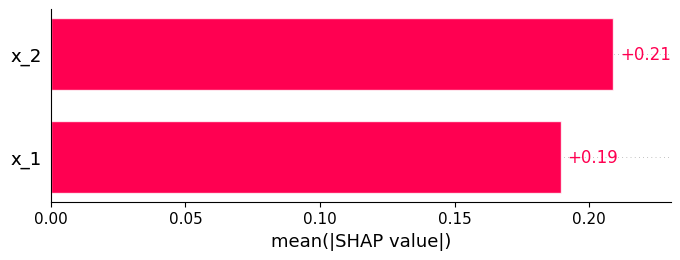

In [77]:
shap.plots.bar(shap_values_proba)

However, the margin space explanations suggest that $x_2$ is actually much more important.

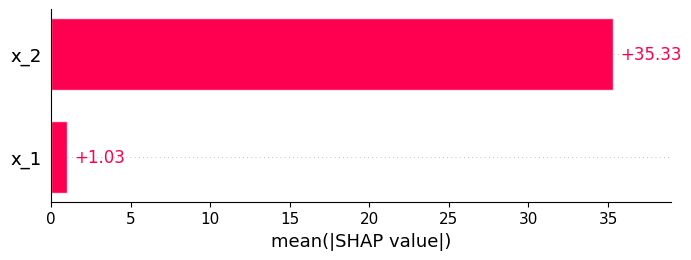

In [78]:
shap.plots.bar(shap_values_margin)

Remember, these bar charts reflect an average over the dataset being examined.  So far, that has been these 3 data point in $X_{\rm test}$.  However, bias in the location of these points can affect your overall impression!  

---
> ❓ What would have happened if we didn't have the 3rd point in our test set?
---

Let's recompute the Shapley values, but on the entire training set.

In [79]:
shap_values_margin = explainer_margin(X)
shap_values_proba = explainer_proba(X)

shap_values_proba.feature_names = ['x_1', 'x_2']
shap_values_margin.feature_names = ['x_1', 'x_2']

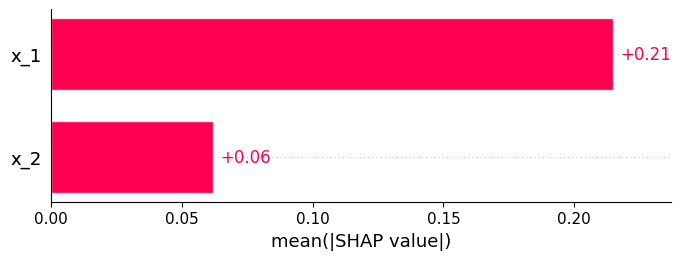

In [80]:
shap.plots.bar(shap_values_proba)

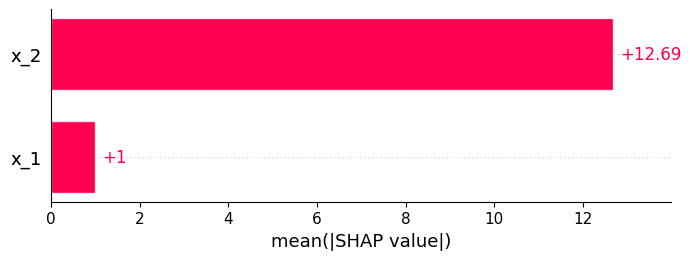

In [81]:
shap.plots.bar(shap_values_margin)

Clearly, we now have opposite opinions about which feature is the most important overall!  The frequency with which different instances in $X$ appear affects this conclusion.  In probability space, the rarity of $x_2 > 1.5$ suppresses the average absolute SHAP value since the magnitude of its impact is compressed by the "squashing function"; despite the rarity, the fact that the impact is not "squashed" in margin space means the average absolute SHAP value for $x_2$ outweights that of $x_1$.

🤔 What can we conclude from all of this?

👉 The margin explanation tells you more about how you "move" around the latent or feature space, while the probability explanation reflects the impact that moving around in different regions.

The reason I feel that margin space explanations are generally better for chemometric applications is that it reflects which features "move" you around the most.

Recall that most chemometric authentication models follow a familiar set of steps:

1. ⬇ Perform dimensionality reduction on a training set of data,
2. 💭 Draw a "bubble" around the data in the lower dimensional space assuming it is normally distributed (usually using a Mahalanobis distance),
3. 📏 Use $\chi^2$ statistics to determine how "far" a sample can be from the center of the distribution and still be considered a class member.

Therefore, features which strongly affect the "position" of a point in the latent space have the strongest capacity to move you toward or away from a decision boundary (in/outside of the bubble). For example, above we used SHAP to explain which features "move" you along the eigenvectors (loadings) in PCA.

🕵 Even if an extreme value of a component in a material or mixture is fairly rare, if the model is sensitive to it then a nefarious actor could try to add or remove this to fool the model so we should know about it. Using the probability explanation over the training set of known, authentic samples can mask the affects that rare or unusual features have on the model where "rare" refers to the frequency with which they occur in the known samples.  In an "open world" 🌎 setting, that scarcity may not be true; or worse could be intentionally manipulated to fool a model.

Probability Calibration

---

There is another reason that using probability explanations is problematic.  Consider a DD-SIMCA model.  For such a model, a sample is accepted as a class member if its "distance" is less than some critical cutoff

$$
d^2(h, q) = N_h \frac{h}{h_0} + N_q \frac{q}{q_0}
$$

However, what is the "probability" of being a class member? 🤷 The margin is the difference between a critical threshold distance and $d^2$; in principle, we could "squash" the difference with a logistic function to obtain a bounded "probability" as we do for logistic regression.  

🤔 However, what does this truly mean?  It is really just a number we got as an output of a semi-arbitrarily chosen squashing function...

This is a recurring problem with machine learning models.  The "probabilities" they output cannot be directly intrepreted as a confidence level.  For example, if a "well calibrated" model predicts the probability of being in class A or not, then if we collect 100 samples where it is predicted that $p \approx 0.8$ we would expect to be correct for $\sim 80$ samples and incorrect for $\sim 20$ samples.  

Unfortunately, this is not the case in general.  The solution is usually to use another machine learning model (regressor) that predict this confidence level using the "probability" that is output by a given model.  This is called "model calibration" and although [sklearn has a nice discussion and tools for doing this](https://scikit-learn.org/stable/modules/calibration.html#calibrating-a-classifier) it is beyond the scope of what we will cover in this course.

🔍 It is nonetheless important to understand since it illustrates that the "probability" output of a classifier can be spurious; therefore, an explanation of it might not be a good idea anyway.

---

 Scikit-learn defines a convention for classifiers to have a member function called [`predict_proba`](https://scikit-learn.org/stable/glossary.html#term-predict_proba) to be implemented, as well as a [`decision_function`](https://scikit-learn.org/stable/glossary.html#term-decision_function).

 PyChemAuth follows this convention for consistency.  Essentially, the decision_function returns a margin where the sign indicates class membership (like with logistic regression illustrated above), and the predict_proba is the [logistic function](https://en.wikipedia.org/wiki/Logistic_function) of this margin.

---
> ❗ Look at the documentation for several PyChemAuth classifiers and authenticators.
---

In [82]:
from pychemauth.classifier.pca import PCA
model = PCA()
?model.decision_function

In [83]:
?model.predict_proba

In [84]:
from pychemauth.classifier.simca import DDSIMCA_Model
model = DDSIMCA_Model(n_components=1)
?model.decision_function

In [85]:
?model.predict_proba


### Best Practices

* Although [shap.Explainer](https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html#shap.Explainer) is meant to be the primary interface to the SHAP library, this selects algorithms it deems "optimal" for the parameters it was given.  ⚠ The logic behind this is subject to change without notice. While convenient, this hides details that can impede reproducibility so it is best to invoke the explainer that best fits your use case.  While there are 🏃 [optimized explainers for different types of models](https://shap.readthedocs.io/en/latest/api.html), sticking to a model-agnostic one means you can stick with the same approach for all the pipeline you might train, so we generally recommend you take this approach.  Which explainer to use generally depends on the "width" of the $X$ matrix you have to deal with:
    * Use an [exact](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/explainers/Exact.html) explainer when possible.  This typically works reasonably well on datasets with 10-100 features, which is fairly common in chemometric applications; e.g., if dealing with stable isotope and trace element data.
    * Sometimes there are more features than this; e.g., when dealing with spectral data (mass, NMR, etc.).  In this case, it is recommended to use a [permutation](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/explainers/Permutation.html) explainer instead.  Although approximate, it still has the properties that attributions "add up" correctly.
* Always specify random number generator seeds as integers when possible to ensure reproducibility.
* You should generally with with standardized data so your explanations are not skewed by feature magnitudes unless they are meaningful.
* Do explanations in unbounded margin space.
    * For regression and dimensionality reduction routines this is typically just the raw output (`model.predict` or `model.transform`).
    * For classification or authentication models, use the `decision_function` instead of `predict_proba` to obtain the margin space output.

# Do I Need More Data?

🤔 After building models, comparing them, and explaining the chosen one(s) researchers are often left with the lingering question: "if I had more data, could I make the model better?"  Consider that a model with high bias is not generally improved by adding more data, where as a model with high variance (sensitivity to the exact data collected) could benefit greatly from this.

Since it is generally too difficult or expensive 💰 to go and collect more data, we can instead resort to doing the opposite: pretend we have only a fraction of the data we really do and see how our modeling pipeline would have performed if that was all we had to work with.  If we repeat this multiple times with smaller and smaller fractions, we can build a curve showing how a model / pipeline performs as the amount of training data varies.

❗ These are called [learning curves](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curve).

Consider this example from [sklearn](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curve).  

* On the left, the test and training scores for a GaussianNB classifier converge to a relatively low value. This is a sign the model has high bias.
* On the right, when there is a small amount of data available there is a large gap between these curves, which is slowly converging as more data is added. The near convergence to a high performance value shows there is a good balance for this SVC model, though it could continue to improve if more data was collected.

![image](https://scikit-learn.org/stable/_images/sphx_glr_plot_learning_curve_001.png)

In principle, we can extrapolate this curve to see how the pipeline will perform - i.e., what is the expected improvement with a certain amount of additional data.  This extrapolation can be tricky and should be viewed with care since the curves are not always smooth, but it can still serve as useful tool.

⭐ PyChemAuth provides a [tutorial](https://pychemauth.readthedocs.io/en/latest/jupyter/api/learning_curves.html) on using this technique.
